<h1>Data preprocessing</h1>

### Feature engineering:

Converted remaining_lease into numeric years.
Ordinal-encoded storey_range to capture floor-level hierarchy.
Dropped unnecessary columns (street name, latitude/longitude, nearest amenities) to avoid noise.

### Feature engineering:

Converted remaining_lease into numeric years.
Ordinal-encoded storey_range to capture floor-level hierarchy.
Dropped unnecessary columns (street name, latitude/longitude, nearest amenities) to avoid noise.

### Data splitting:

Train/test split at 75/25 with random_state=42 for reproducibility.

### Class balancing:

Calculated sample weights based on (town, flat_type, flat_model) to reduce bias toward over-represented combinations.

### Preprocessing:

One-hot encoding for categorical features.
Standard scaling for numeric features.
Target (resale_price) scaled with QuantileTransformer to normal distribution — improves linear model fit.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('data/dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

print('Converting Remaining Lease into numerical:')
print(df[['remaining_lease', 'remaining_lease_years']].head(10))

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

print('Ordinally encoded storey range by taking the in-between storeys (floors 01-03 becomes 2):')
print(df[['storey_ordinal', 'storey_range']].head(10))

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

Converting Remaining Lease into numerical:
      remaining_lease  remaining_lease_years
0  61 years 04 months              61.333333
1  60 years 07 months              60.583333
2  62 years 05 months              62.416667
3   62 years 01 month              62.083333
4  62 years 05 months              62.416667
5            63 years              63.000000
6  61 years 06 months              61.500000
7  58 years 04 months              58.333333
8  61 years 06 months              61.500000
9  61 years 04 months              61.333333
Ordinally encoded storey range by taking the in-between storeys (floors 01-03 becomes 2):
   storey_ordinal storey_range
0              11     10 TO 12
1               2     01 TO 03
2               2     01 TO 03
3               5     04 TO 06
4               2     01 TO 03
5               2     01 TO 03
6               5     04 TO 06
7               5     04 TO 06
8               5     04 TO 06
9               2     01 TO 03


<h1>Modelling</h1>

In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<h2>Linear Regression (baseline, no regularization)</h2>

--- Training Linear Regression ---
Linear Regression RMSE: 81150.0720
Linear Regression MAE:  61813.3750



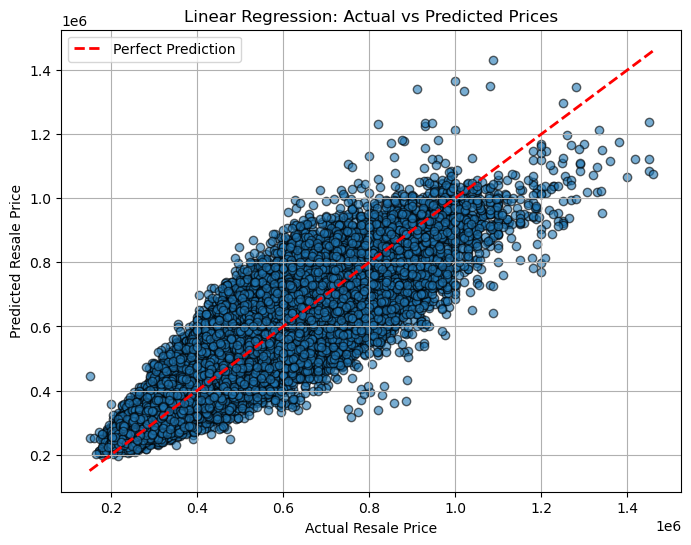

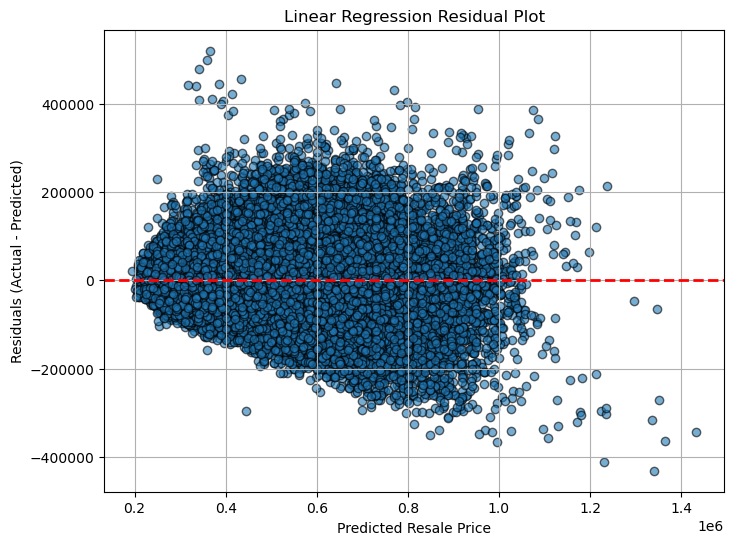

In [ ]:
print("--- Training Linear Regression ---")
# LinearRegression doesn't have major hyperparameters to tune with GridSearchCV in this context
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_scaled, sample_weight=sample_weights)
y_pred_lr = lr_model.predict(X_test)
y_pred_lr = scaler.inverse_transform(y_pred_lr.reshape(-1, 1))
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression MAE:  {mae_lr:.4f}\n")

import matplotlib.pyplot as plt
import numpy as np

# --- Visualization ---
plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

# --- Residual Plot ---
residuals = y_test - y_pred_lr.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Resale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Linear Regression Residual Plot")
plt.grid(True)
plt.show()

## Ridge Regression and Lasso Regression

Ridge Regression (L2 regularization — reduces variance but similar to linear if penalty is small)

Lasso Regression (L1 regularization — feature selection effect)

--- Tuning Ridge Regression ---
Best Ridge alpha: 0.01
Ridge RMSE: 81150.0721
Ridge MAE:  61813.3751

--- Tuning Lasso Regression ---
Best Lasso alpha: 0.0001
Lasso RMSE: 81150.3676
Lasso MAE:  61813.8435



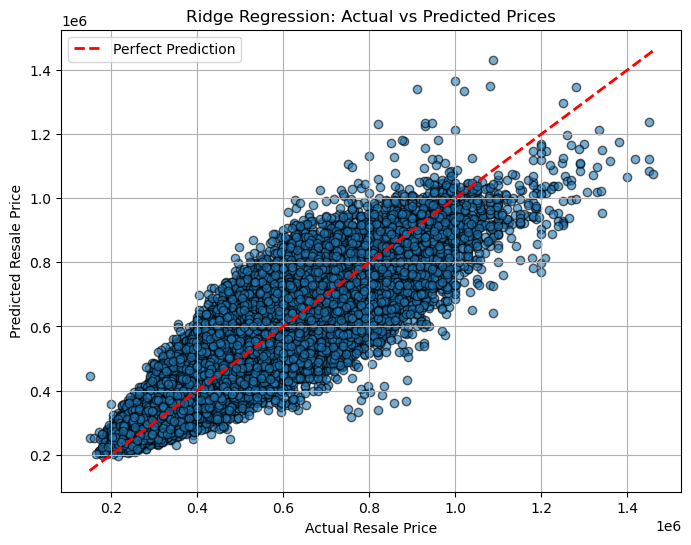

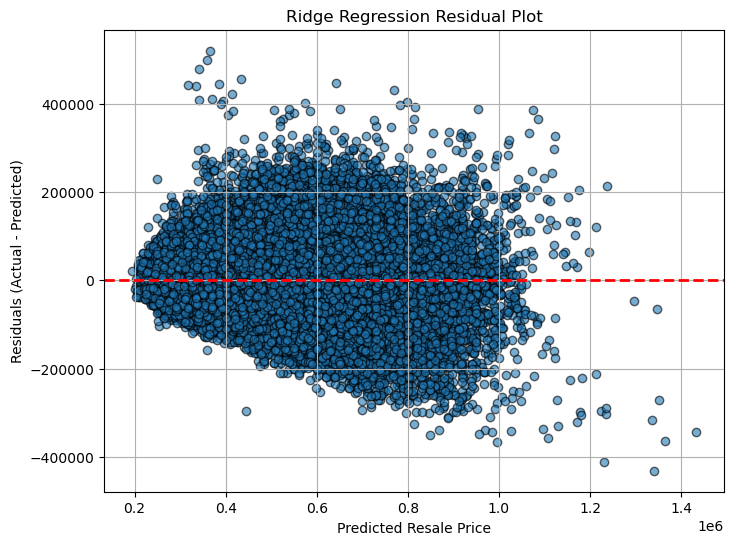

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ✅ Ensure no non-numeric columns remain
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print("Dropping non-numeric columns:", list(non_numeric_cols))
    X_train = X_train.drop(columns=non_numeric_cols)
    X_test = X_test.drop(columns=non_numeric_cols)

# ==============================
# Ridge Regression Tuning
# ==============================
print("--- Tuning Ridge Regression ---")
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)
ridge_grid.fit(X_train, y_train_scaled, sample_weight=sample_weights)

best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
y_pred_ridge = scaler.inverse_transform(y_pred_ridge.reshape(-1, 1))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")
print(f"Ridge RMSE: {rmse_ridge:.4f}")
print(f"Ridge MAE:  {mae_ridge:.4f}\n")

# ==============================
# Lasso Regression Tuning
# ==============================
print("--- Tuning Lasso Regression ---")
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso = Lasso(random_state=42, max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)
lasso_grid.fit(X_train, y_train_scaled, sample_weight=sample_weights)

best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
y_pred_lasso = scaler.inverse_transform(y_pred_lasso.reshape(-1, 1))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(f"Best Lasso alpha: {lasso_grid.best_params_['alpha']}")
print(f"Lasso RMSE: {rmse_lasso:.4f}")
print(f"Lasso MAE:  {mae_lasso:.4f}\n")

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Ridge Regression: Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

# --- Visualization: Residual Plot ---
residuals_ridge = y_test - y_pred_ridge.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.6, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Resale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Ridge Regression Residual Plot")
plt.grid(True)
plt.show()


## Comparison Plot against Linear vs Ridge vs Lasso

Linear Regression RMSE: 81150.0720, MAE: 61813.3750
Ridge Regression RMSE: 81150.0721, MAE: 61813.3751
Lasso Regression RMSE: 81150.3676, MAE: 61813.8435


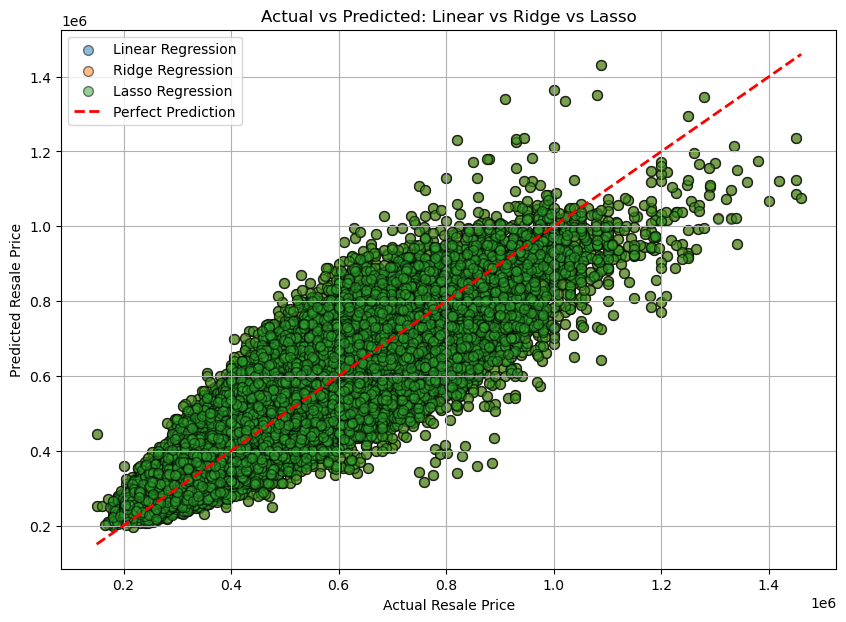

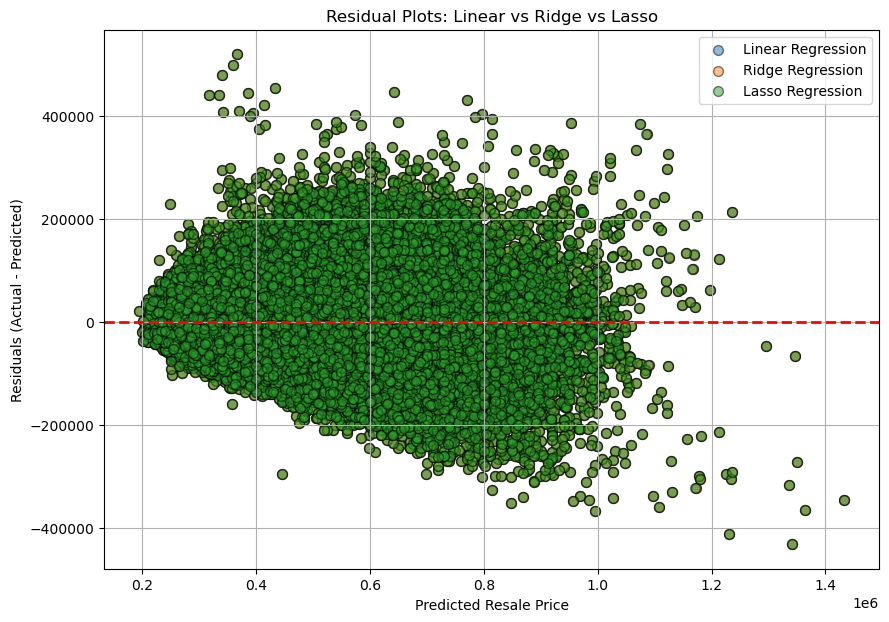

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# --- Helper function for training and predicting ---
def train_and_predict(model, model_name):
    model.fit(X_train, y_train_scaled, sample_weight=sample_weights)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, rmse, mae

# --- Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.01),
    "Lasso Regression": Lasso(alpha=0.0001)
}

predictions = {}
metrics = {}

# --- Train each model ---
for name, model in models.items():
    y_pred, rmse, mae = train_and_predict(model, name)
    predictions[name] = y_pred
    metrics[name] = (rmse, mae)
    print(f"{name} RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# --- Combined Plot: Actual vs Predicted ---
plt.figure(figsize=(10, 7))
for name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, alpha=0.5, label=f"{name}", edgecolors='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Actual vs Predicted: Linear vs Ridge vs Lasso")
plt.legend()
plt.grid(True)
plt.show()

# --- Combined Plot: Residuals ---
plt.figure(figsize=(10, 7))
for name, y_pred in predictions.items():
    residuals = y_test - y_pred.flatten()
    plt.scatter(y_pred, residuals, alpha=0.5, label=f"{name}", edgecolors='k', s=50)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Resale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plots: Linear vs Ridge vs Lasso")
plt.legend()
plt.grid(True)
plt.show()


## Comparison against Linear vs Ridge vs Lasso and Polynomial regression (L2)

Polynomial Regression (degree=2) (adds interaction & quadratic terms for non-linear relationships)

Linear Regression RMSE: 81150.0720, MAE: 61813.3750
Ridge Regression RMSE: 81150.0721, MAE: 61813.3751
Lasso Regression RMSE: 81150.3676, MAE: 61813.8435
Polynomial Regression (deg=2) RMSE: 67946.0500, MAE: 50985.9996


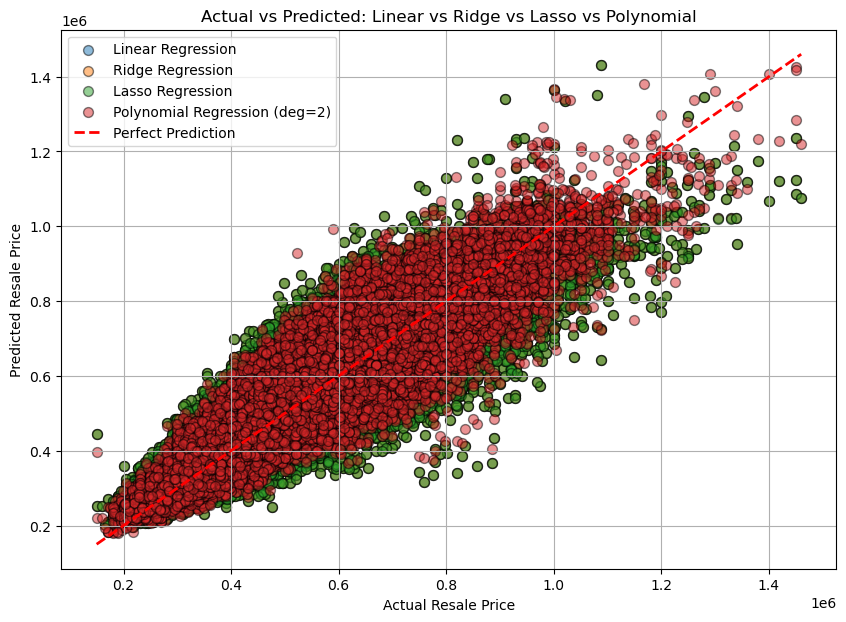

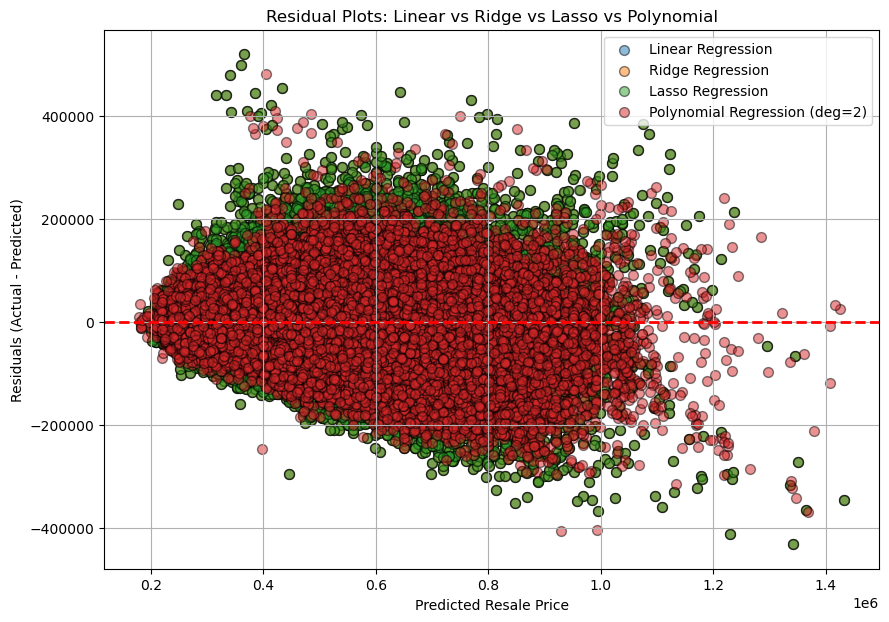

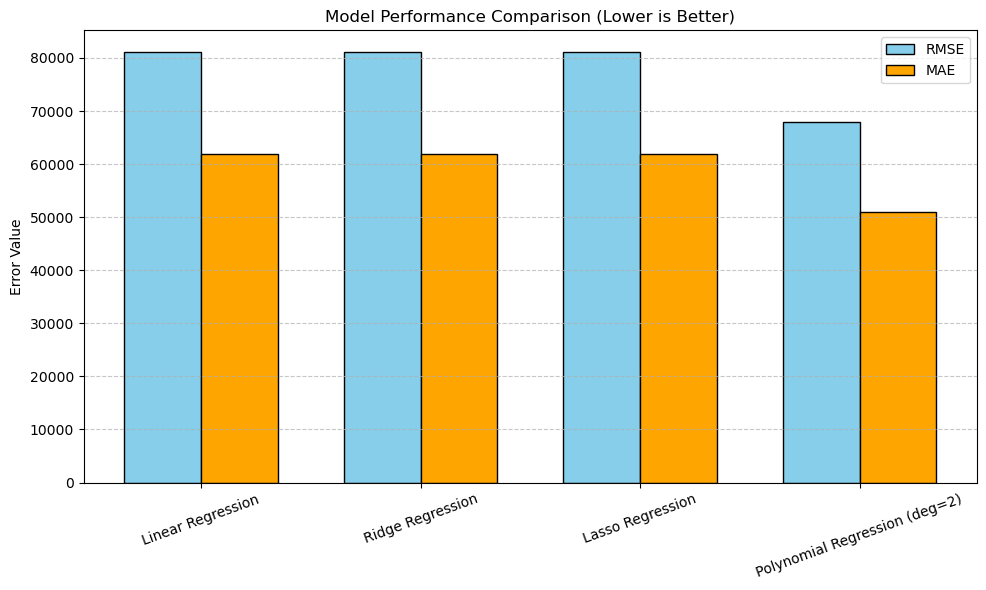

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# --- Helper function for training and predicting ---
def train_and_predict(model, model_name, use_pipeline=False):
    if use_pipeline:
        # Fit pipeline with sample_weight passed to last estimator
        model.fit(X_train, y_train_scaled, linear__sample_weight=sample_weights)
        y_pred_scaled = model.predict(X_test)
    else:
        model.fit(X_train, y_train_scaled, sample_weight=sample_weights)
        y_pred_scaled = model.predict(X_test)

    # Reverse scaling
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, rmse, mae

# --- Models ---
models = {
    "Linear Regression": (LinearRegression(), False),
    "Ridge Regression": (Ridge(alpha=0.01), False),
    "Lasso Regression": (Lasso(alpha=0.0001), False),
    "Polynomial Regression (deg=2)": (
        Pipeline([
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("linear", LinearRegression())
        ]),
        True
    )
}

predictions = {}
metrics = {}

# --- Train each model ---
for name, (model, is_pipeline) in models.items():
    y_pred, rmse, mae = train_and_predict(model, name, use_pipeline=is_pipeline)
    predictions[name] = y_pred
    metrics[name] = (rmse, mae)
    print(f"{name} RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# --- Combined Plot: Actual vs Predicted ---
plt.figure(figsize=(10, 7))
for name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, alpha=0.5, label=f"{name}", edgecolors='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Actual vs Predicted: Linear vs Ridge vs Lasso vs Polynomial")
plt.legend()
plt.grid(True)
plt.show()

# --- Combined Plot: Residuals ---
plt.figure(figsize=(10, 7))
for name, y_pred in predictions.items():
    residuals = y_test - y_pred.flatten()
    plt.scatter(y_pred, residuals, alpha=0.5, label=f"{name}", edgecolors='k', s=50)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Resale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plots: Linear vs Ridge vs Lasso vs Polynomial")
plt.legend()
plt.grid(True)
plt.show()

# --- Bar Chart: RMSE & MAE Comparison ---
model_names = list(metrics.keys())
rmse_values = [metrics[m][0] for m in model_names]
mae_values = [metrics[m][1] for m in model_names]

x = np.arange(len(model_names))  # X positions
width = 0.35  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rmse_values, width, label="RMSE", color='skyblue', edgecolor='black')
plt.bar(x + width/2, mae_values, width, label="MAE", color='orange', edgecolor='black')

plt.xticks(x, model_names, rotation=20)
plt.ylabel("Error Value")
plt.title("Model Performance Comparison (Lower is Better)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np

# Pipeline: PolynomialFeatures -> Ridge
poly_ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

# Grid search parameters
param_grid_poly_ridge = {
    'poly__degree': [2],  # try [2, 3] for more complexity
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Grid search
poly_ridge_grid = GridSearchCV(
    estimator=poly_ridge_pipeline,
    param_grid=param_grid_poly_ridge,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# IMPORTANT: Pass sample_weight to the Ridge step
poly_ridge_grid.fit(
    X_train,
    y_train_scaled,
    ridge__sample_weight=sample_weights
)

# Best model
best_poly_ridge = poly_ridge_grid.best_estimator_
y_pred_poly_ridge = best_poly_ridge.predict(X_test)
y_pred_poly_ridge = scaler.inverse_transform(y_pred_poly_ridge.reshape(-1, 1))

# Metrics
rmse_poly_ridge = np.sqrt(mean_squared_error(y_test, y_pred_poly_ridge))
mae_poly_ridge = mean_absolute_error(y_test, y_pred_poly_ridge)

print(f"Best Polynomial Ridge params: {poly_ridge_grid.best_params_}")
print(f"Polynomial Ridge RMSE: {rmse_poly_ridge:.4f}")
print(f"Polynomial Ridge MAE:  {mae_poly_ridge:.4f}")


Best Polynomial Ridge params: {'poly__degree': 2, 'ridge__alpha': 0.001}
Polynomial Ridge RMSE: 67922.1264
Polynomial Ridge MAE:  50971.9881


## From your output:

Model: RMSE , MAE

Linear Regression: 81,150.07 , 61,813.38

Ridge Regression: 81,150.07 , 61,813.38

Lasso Regression: 81,150.37 , 61,813.84

Polynomial Regression (deg=2): 67,946.05 , 50,986.00

## Linear, Ridge, and Lasso gave almost identical results which means:

The features already have low multicollinearity.

Regularization didn’t help because the model’s bias was the main limitation, not variance.

The relationship between features and target is not purely linear — hence no big gain here.

Polynomial Regression (degree=2) gave much lower RMSE ( ~ 16% improvement) and MAE ( ~ 17% improvement)

Adding interaction and quadratic terms captured non-linear patterns in resale price that linear models couldn’t.

## Best Approach
Based on lowest RMSE & MAE,
Polynomial Regression (degree=2) is the best choice here.

--- Training Linear Regression ---
Linear Regression RMSE: 81150.0720, MAE: 61813.3750
--- Training Ridge Regression ---
Ridge Regression RMSE: 81150.0749, MAE: 61813.3796
--- Training Lasso Regression ---
Lasso Regression RMSE: 81153.1439, MAE: 61818.2686
--- Training Polynomial Regression (deg=2) ---
Polynomial Regression (deg=2) RMSE: 67946.0500, MAE: 50985.9996
--- Training Polynomial Regression (deg=3) ---
Polynomial Regression (deg=3) RMSE: 52366.6517, MAE: 39148.5201


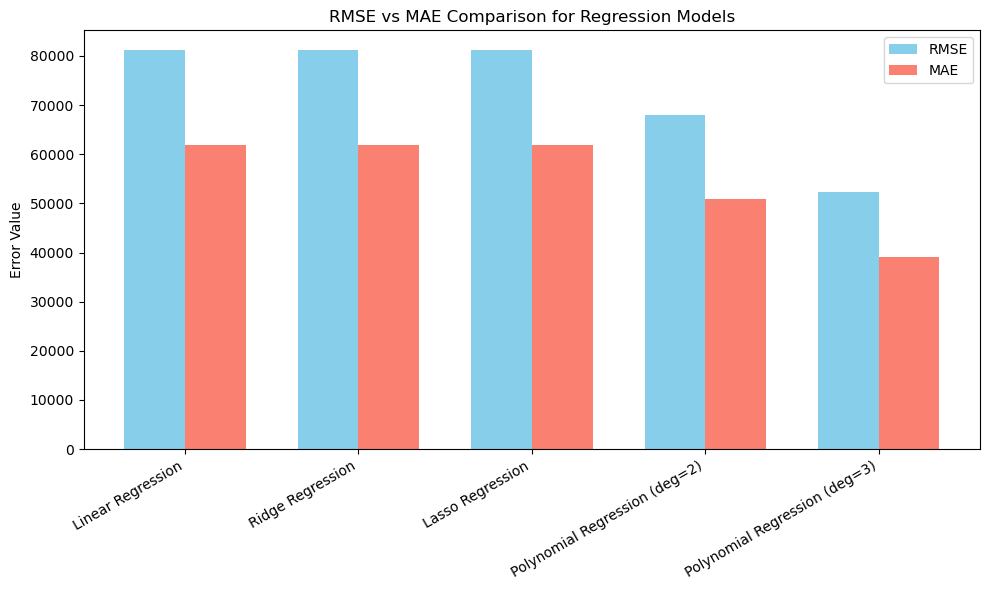

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Assume X_train, X_test, y_train_scaled, y_test, scaler, sample_weights are already defined ---

# Storage for results
predictions = {}
metrics = {}

# Helper function
def train_and_predict(model, model_name):
    print(f"--- Training {model_name} ---")

    fit_params = {}
    if hasattr(model, "steps"):  # Pipeline
        last_step_name, _ = model.steps[-1]
        fit_params[f"{last_step_name}__sample_weight"] = sample_weights
    else:  # Normal model
        fit_params["sample_weight"] = sample_weights

    # Fit model
    model.fit(X_train, y_train_scaled, **fit_params)

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    predictions[model_name] = y_pred
    metrics[model_name] = (rmse, mae)

    return y_pred, rmse, mae

# --- Train all models ---

# Linear Regression
train_and_predict(LinearRegression(), "Linear Regression")

# Ridge Regression
train_and_predict(Ridge(alpha=1.0), "Ridge Regression")

# Lasso Regression
train_and_predict(Lasso(alpha=0.001, max_iter=10000), "Lasso Regression")

# Polynomial Regression (deg=2)
poly2_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linreg', LinearRegression())
])
train_and_predict(poly2_pipeline, "Polynomial Regression (deg=2)")

# Polynomial Regression (deg=3)
poly3_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('linreg', LinearRegression())
])
train_and_predict(poly3_pipeline, "Polynomial Regression (deg=3)")

# --- Visualization ---
model_names = list(metrics.keys())
rmse_values = [metrics[m][0] for m in model_names]
mae_values = [metrics[m][1] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
plt.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

plt.xticks(x, model_names, rotation=30, ha='right')
plt.ylabel("Error Value")
plt.title("RMSE vs MAE Comparison for Regression Models")
plt.legend()
plt.tight_layout()
plt.show()


## Final Conclusion

Our data benefits a lot from non-linear modeling. Linear methods (with or without regularization) are leaving too much unexplained variance. Polynomial degree 3 is currently the best.